_Lambda School Data Science — Model Validation_ 

# Validate classification problems

Objectives
- Imbalanced Classes
- Confusion Matrix
- ROC AUC


Reading
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)
- [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall)

## Preliminary

We'll use [mlxtend](http://rasbt.github.io/mlxtend/) and [yellowbrick](http://www.scikit-yb.org/en/latest/) for visualizations. These libraries are already installed on Google Colab. But if you are running locally with Anaconda Python, you'll probably need to install them:

```
conda install -c conda-forge mlxtend 
conda install -c districtdatalabs yellowbrick
```

We'll reuse the `train_validation_test_split` function from yesterday's lesson.

In [ ]:
from sklearn.model_selection import train_test_split

def train_validation_test_split(
    X, y, train_size=0.8, val_size=0.1, test_size=0.1, 
    random_state=None, shuffle=True):
        
    assert train_size + val_size + test_size == 1
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=shuffle)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size/(train_size+val_size), 
        random_state=random_state, shuffle=shuffle)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

## Fun demo!

The next code cell does five things:

#### 1. Generate data

We use scikit-learn's [make_classification](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) function to generate fake data for a binary classification problem, based on several parameters, including:
- Number of samples
- Weights, meaning "the proportions of samples assigned to each class."
- Class separation: "Larger values spread out the clusters/classes and make the classification task easier."

(We are generating fake data so it is easy to visualize.)

#### 2. Split data

We split the data three ways, into train, validation, and test sets. (For this toy example, it's not really necessary to do a three-way split. A two-way split, or even no split, would be ok. But I'm trying to demonstrate good habits, even in toy examples, to avoid confusion.)

#### 3. Fit model

We use scikit-learn to fit a [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) on the training data.

We use this model parameter:

> **class_weight : _dict or ‘balanced’, default: None_**

> Weights associated with classes in the form `{class_label: weight}`. If not given, all classes are supposed to have weight one.

> The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as `n_samples / (n_classes * np.bincount(y))`.


#### 4. Evaluate model

We use our Logistic Regression model, which was fit on the training data, to generate predictions for the validation data.

Then we print [scikit-learn's Classification Report](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report), with many metrics, and also the accuracy score. We are comparing the correct labels to the Logistic Regression's predicted labels, for the validation set. 

#### 5. Visualize decision function

Based on these examples
- https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/combine/plot_comparison_combine.html
- http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/#example-1-decision-regions-in-2d

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_decision_regions


#1. Generate data

# Try re-running the cell with different values for these parameters
n_samples = 1000
weights = (0.50, 0.50)
class_sep = 0.8

X, y = make_classification(n_samples=n_samples, n_features=2, n_informative=2, 
                           n_redundant=0, n_repeated=0, n_classes=2, 
                           n_clusters_per_class=1, weights=weights, 
                           class_sep=class_sep, random_state=0)


# 2. Split data

# Uses our custom train_validation_test_split function
X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(
    X, y, train_size=0.8, val_size=0.1, test_size=0.1, random_state=1)


# 3. Fit model

# Try re-running the cell with different values for this parameter
class_weight = None

model = LogisticRegression(solver='lbfgs', class_weight=class_weight)
model.fit(X_train, y_train)


# 4. Evaluate model

y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))
print('accuracy', accuracy_score(y_val, y_pred))


# 5. Visualize decision regions

plt.figure(figsize=(10, 6))
plot_decision_regions(X_val, y_val, model, legend=0);

Try re-running the cell above with different values for these four parameters:
- `n_samples`
- `weights`
- `class_sep`
- `class_balance`

For example, with a 50% / 50% class distribution:
```
n_samples = 1000
weights = (0.50, 0.50)
class_sep = 0.8
class_balance = None
```

With a 95% / 5% class distribution:
```
n_samples = 1000
weights = (0.95, 0.05)
class_sep = 0.8
class_balance = None
```

With the same 95% / 5% class distribution, but changing the Logistic Regression's `class_balance` parameter to `'balanced'` (instead of its default `None`)
```
n_samples = 1000
weights = (0.95, 0.05)
class_sep = 0.8
class_balance = 'balanced'
```

With the same 95% / 5% class distribution, but with different values for `class_balance`:
- `{0: 1, 1: 1}` _(equivalent to `None`)_
- `{1: 1, 1: 2}`
- `{1: 1, 1: 10}` _(roughly equivalent to `'balanced'` for this dataset)_
- `{1: 1, 1: 100}`
- `{1: 1, 1: 10000}`

How do the evaluation metrics and decision region plots change?

## What you can do about imbalanced classes

[Learning from Imbalanced Classes](https://www.svds.com/tbt-learning-imbalanced-classes/) gives "a rough outline of useful approaches" : 

- Do nothing. Sometimes you get lucky and nothing needs to be done. You can train on the so-called natural (or stratified) distribution and sometimes it works without need for modification.
- Balance the training set in some way:
  - Oversample the minority class.
  - Undersample the majority class.
  - Synthesize new minority classes.
- Throw away minority examples and switch to an anomaly detection framework.
- At the algorithm level, or after it:
  - Adjust the class weight (misclassification costs).
  - Adjust the decision threshold.
  - Modify an existing algorithm to be more sensitive to rare classes.
- Construct an entirely new algorithm to perform well on imbalanced data.


We demonstrated just one of these options: many scikit-learn classifiers have a `class_balance` parameter, which we can use to "adjust the class weight (misclassification costs)."

The [imbalance-learn](https://github.com/scikit-learn-contrib/imbalanced-learn) library can be used to "oversample the minority class, undersample the majority class, or synthesize new minority classes."

You can see how to "adjust the decision threshold" in a great blog post, [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415).

## Bank Marketing — getting started

https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

bank-additional-full.csv with all examples (41188) and 20 inputs, **ordered by date (from May 2008 to November 2010)**

### Download data

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip

In [ ]:
!unzip bank-additional.zip

In [ ]:
%cd bank-additional

### Load data, assign to X and y

In [ ]:
import pandas as pd

bank = pd.read_csv('bank-additional-full.csv', sep=';')

X = bank.drop(columns='y')
y = bank['y'] == 'yes'

### Split data

We want to do "model selection (hyperparameter optimization) and performance estimation" so we'll choose a validation method from the diagram's green box.

There is no one "right" choice here, but I'll choose "3-way holdout method (train/validation/test split)."
  
<img src="https://sebastianraschka.com/images/blog/2018/model-evaluation-selection-part4/model-eval-conclusions.jpg" width="600">

Source: https://sebastianraschka.com/blog/2018/model-evaluation-selection-part4.html

There's no one "right" choice here, but I'll choose to split by time, not with a random shuffle, based on this advice by [Rachel Thomas](
https://www.fast.ai/2017/11/13/validation-sets/):
> If your data is a time series, choosing a random subset of the data will be both too easy (you can look at the data both before and after the dates your are trying to predict) and not representative of most business use cases (where you are using historical data to build a model for use in the future).

[According to UCI](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing), this data is "ordered by date (from May 2008 to November 2010)" so if I don't shuffle it when splitting, then it will be split by time.

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(
    X, y, shuffle=False)

## Bank Marketing — live coding!

# ASSIGNMENT options

Replicate code from the lesson or other examples. [Do it "the hard way" or with the "Benjamin Franklin method."](https://docs.google.com/document/d/1ubOw9B3Hfip27hF2ZFnW3a3z9xAgrUDRReOEo-FHCVs/edit)

Work with one of these datasets
- [Bank Marketing](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing)
- [Synthetic Financial Dataset For Fraud Detection](https://www.kaggle.com/ntnu-testimon/paysim1)
- Any imbalanced binary classification dataset

Continue improving your model. Measure validation performance with a variety of classification metrics, which could include:
- Accuracy
- Precision
- Recall
- F1
- ROC AUC

Try one of the other options mentioned for imbalanced classes
- The [imbalance-learn](https://github.com/scikit-learn-contrib/imbalanced-learn) library can be used to "oversample the minority class, undersample the majority class, or synthesize new minority classes."
- You can see how to "adjust the decision threshold" in a great blog post, [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415).

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import zipfile 
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV
import seaborn as sns 

In [2]:
zf = zipfile.ZipFile('C:/Users/dakot/Downloads/paysim1.zip')
df = pd.read_csv(zf.open(zipfile.ZipFile.namelist(zf)[0]))

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:

df = df.drop(columns = ['nameOrig','nameDest', 'isFlaggedFraud'], axis = 1)

In [10]:
df.shape

(6362620, 8)

In [11]:
df.isna().sum().sum()

0

In [12]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00


In [13]:
df.corr()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000


In [14]:
def train_validation_test_split(
    X, y, train_size=0.8, val_size=0.1, test_size=0.1, 
    random_state=None, shuffle=True):
        
    assert train_size + val_size + test_size == 1
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=shuffle)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size/(train_size+val_size), 
        random_state=random_state, shuffle=shuffle)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [27]:
#Isolate the tranfer and cashout transaction types 
X =df.loc[(df.type=='TRANSFER') | (df.type == 'CASH_OUT')]
y= X['isFraud']
X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(
    X, y, train_size=0.6, val_size=0.2, test_size=0.2, random_state=42)


In [28]:
X.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2,1,TRANSFER,181.00,181.0,0.0,0.0,0.00,1
3,1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,1
15,1,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0
19,1,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,0
24,1,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,0


In [29]:
print(X.shape,y.shape)

(2770409, 8) (2770409,)


In [30]:
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int)

C:\Users\dakot\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\dakot\Anaconda3\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [34]:
X['eBalanceOg'] = X.newbalanceOrig + X.amount - X.oldbalanceOrg
X['eBalanceDest'] = X.oldbalanceDest + X.amount - X.newbalanceDest

C:\Users\dakot\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\dakot\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [35]:
X.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,eBalanceOg,eBalanceDest
2,1,0,181.00,181.0,0.0,0.0,0.00,1,0.00,181.0
3,1,1,181.00,181.0,0.0,21182.0,0.00,1,0.00,21363.0
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44,0,213808.94,182703.5
19,1,0,215310.30,705.0,0.0,22425.0,0.00,0,214605.30,237735.3
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89,0,300850.89,-2401220.0


In [36]:
%%time
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    StandardScaler(), 
    LogisticRegression(solver='lbfgs')
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

C:\Users\dakot\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\dakot\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Wall time: 7.69 s


C:\Users\dakot\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [38]:
print(X_train.shape,y_train.shape)

(1662245, 8) (1662245,)


In [39]:
roc_auc_score(y_val, y_pred)

1.0

In [40]:
print(classification_report(y_val, y_pred))
print('accuracy', accuracy_score(y_val, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552492
           1       1.00      1.00      1.00      1590

   micro avg       1.00      1.00      1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082

accuracy 1.0


In [42]:
#DO NOT RUN LOCALLY WITHOUT 32G RAM INSTALLED!
param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

y_pred_grid = grid.predict(X_test)

print("Baseline:")
print()
print("Best parameters: {}".format(grid.best_params_))
print()
print("Best CV scores: {:.2f}".format(grid.best_score_))
print()
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))


C:\Users\dakot\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\dakot\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\dakot\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Baseline:

Best parameters: {'logisticregression__C': 0.001}

Best CV scores: 1.00

Test set score: 1.00


C:\Users\dakot\Anaconda3\lib\site-packages\sklearn\pipeline.py:511: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [43]:
y_val.value_counts(normalize=True)

0    0.99713
1    0.00287
Name: isFraud, dtype: float64

In [44]:
n_samples = 1000
weights = ({0:1,1:10000000000})
class_sep = 0.8

X, y = make_classification(n_samples=n_samples, n_features=2, n_informative=2, 
                           n_redundant=0, n_repeated=0, n_classes=2, 
                           n_clusters_per_class=1, weights=weights, 
                           class_sep=class_sep, random_state=42)


In [45]:
print(classification_report(y_val, y_pred))
print('accuracy', accuracy_score(y_val, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552492
           1       1.00      1.00      1.00      1590

   micro avg       1.00      1.00      1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082

accuracy 1.0


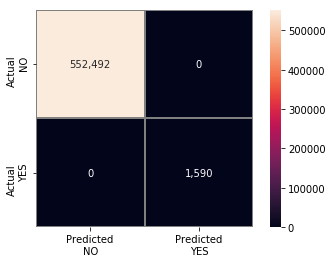

In [46]:
from sklearn.metrics import confusion_matrix
def confusion_viz(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred)
    return sns.heatmap(matrix, annot=True, 
                       fmt=',', linewidths=1, linecolor='grey', 
                       square=True, 
                       xticklabels=['Predicted\nNO', 'Predicted\nYES'], 
                       yticklabels=['Actual\nNO', 'Actual\nYES'])

confusion_viz(y_val, y_pred);